In [139]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

In [140]:
df_all = pd.read_csv('data/산불데이터에코드매핑+좌표.csv')
df_all.head()

,발생일시_년,발생일시_월,발생일시_일,발생일시_시간,발생일시_요일,진화종료시간_년,진화종료시간_월,진화종료시간_일,진화종료시간_시간,발생장소_관서,...,발생장소_읍면동,발생장소_시도_시군구,발생장소_시도_시군구_읍면동,CTPRVN_CD,SIG_CD,EMD_CD,매핑수준,매핑방법,경도,위도
0,2024,9,29,15:41,일,2024,9,30,16:30,전북,...,산동,전북 남원,전북 남원 산동,45,45190,45190410,완전 매칭,"시도,시군구,읍면동",127.480835,35.501992
1,2024,9,10,15:55,화,2024,9,10,18:00,경남,...,내이,경남 밀양,경남 밀양 내이,48,48270,48270102,완전 매칭,"시도,시군구,읍면동",128.743643,35.497002
2,2024,9,10,14:35,화,2024,9,10,17:52,충남,...,규암,충남 부여,충남 부여 규암,44,44760,44760310,완전 매칭,"시도,시군구,읍면동",126.865710,36.283090
3,2024,9,10,14:24,화,2024,9,10,22:00,경북,...,화동,경북 상주,경북 상주 화동,47,47250,47250400,완전 매칭,"시도,시군구,읍면동",127.972443,36.398004
4,2024,9,5,13:51,목,2024,9,5,16:10,경북,...,녹전,경북 안동,경북 안동 녹전,47,47170,47170430,완전 매칭,"시도,시군구,읍면동",128.767307,36.751290


In [141]:
is_outlier = (df_all['위도'] < 34) | (df_all['경도'] < 125.2)
print(is_outlier.sum(), '개의 이상치가 있습니다.')

6 개의 이상치가 있습니다.


In [142]:
df = df_all[~is_outlier].copy()

In [143]:
# KMeans++ 클러스터링 (k=31 (헬기 총 대수))
coords = df[["위도", "경도"]]
k = 31
kmeans_plus = KMeans(n_clusters=k, init='k-means++', random_state=42)
df['cluster'] = kmeans_plus.fit_predict(coords)
centers = kmeans_plus.cluster_centers_


In [144]:
# Haversine 거리 계산 함수

def haversine_km(x1, y1, x2, y2):
    R = 6371  # 지구 반지름
    to_rad = np.pi / 180

    delta_lat = np.abs(x1 - x2) * to_rad
    delta_lon = np.abs(y1 - y2) * to_rad

    sin_dlat = np.sin(delta_lat / 2)
    sin_dlon = np.sin(delta_lon / 2)

    a = sin_dlat ** 2 + np.cos(x1 * to_rad) * np.cos(x2 * to_rad) * sin_dlon ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

In [145]:
# 평균 거리
avg_distances = []

for i in range(k):
    cluster_points = df[df['cluster'] == i][['위도', '경도']].values
    center_lat, center_lon = centers[i]

    dists = haversine_km(center_lat, center_lon, cluster_points[:, 0], cluster_points[:, 1])
    avg_dist = np.mean(dists)

    avg_distances.append({
        'cluster': i,
        'center_lat': center_lat,
        'center_lon': center_lon,
        'num_fires': len(cluster_points),
        'avg_distance_km': avg_dist
    })

# DataFrame으로 정리
df_cluster_summary = pd.DataFrame(avg_distances)
df_cluster_summary = df_cluster_summary.sort_values(by='avg_distance_km', ascending=False)

In [146]:
df_cluster_summary.head(31)

,cluster,center_lat,center_lon,num_fires,avg_distance_km
13,13,36.902846,129.068489,47,28.322972
22,22,37.989675,127.737876,48,26.935971
14,14,36.552216,128.336290,50,24.846598
17,17,36.257638,129.252472,42,24.746581
9,9,37.138001,128.619133,39,23.348962
4,4,34.495205,126.566131,18,22.613379
5,5,37.813889,126.912460,123,22.518183
2,2,37.396948,127.997548,50,21.942099
11,11,38.169679,128.446324,18,21.152518
20,20,34.684835,127.146818,36,20.924300


In [147]:
df_cluster_summary['avg_distance_km'].describe()

count    31.000000
mean     20.255982
std       3.004574
min      15.591730
25%      17.990352
50%      19.534317
75%      21.547309
max      28.322972
Name: avg_distance_km, dtype: float64

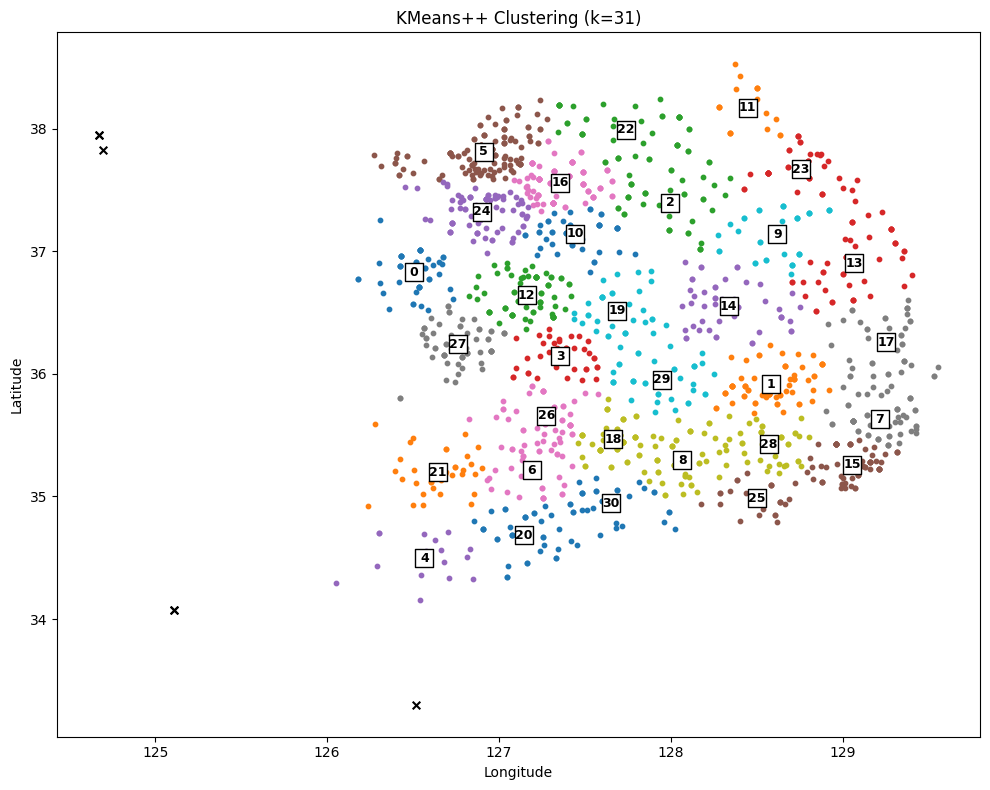

In [148]:
# 시각화
plt.figure(figsize=(10, 8))

for i in range(k):
    cluster_points = df[df['cluster'] == i]
    plt.scatter(cluster_points["경도"], cluster_points["위도"], s=10)

plt.scatter(centers[:, 1], centers[:, 0], c='white', edgecolors='black', marker='s', s=150, label='Centers')

# 중심점 위에 클러스터 번호 텍스트 표시
for i, (lat, lon) in enumerate(centers):
    plt.text(lon, lat, str(i), fontsize=9, color='black', ha='center', va='center', fontweight='bold')

df_outlier = df_all[is_outlier]
plt.scatter(df_outlier['경도'], df_outlier['위도'], s=30, c='black', marker='x', label='Outlier')

plt.title(f'KMeans++ Clustering (k={k})')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(False)
plt.tight_layout()
plt.show()

In [149]:

# KMeans++ 클러스터링 (k=16 (헬기 보유 기관 수(중앙119 제외)))
coords = df[["위도", "경도"]]
k = 16
kmeans_plus = KMeans(n_clusters=k, init='k-means++', random_state=42)
df['cluster'] = kmeans_plus.fit_predict(coords)
centers = kmeans_plus.cluster_centers_


In [150]:
# 평균 거리
avg_distances = []

for i in range(k):
    cluster_points = df[df['cluster'] == i][['위도', '경도']].values
    center_lat, center_lon = centers[i]

    dists = haversine_km(center_lat, center_lon, cluster_points[:, 0], cluster_points[:, 1])
    avg_dist = np.mean(dists)

    avg_distances.append({
        'cluster': i,
        'center_lat': center_lat,
        'center_lon': center_lon,
        'num_fires': len(cluster_points),
        'avg_distance_km': avg_dist
    })

# DataFrame으로 정리
df_cluster_summary = pd.DataFrame(avg_distances)
df_cluster_summary = df_cluster_summary.sort_values(by='avg_distance_km', ascending=False)

In [151]:
df_cluster_summary.head(31)

,cluster,center_lat,center_lon,num_fires,avg_distance_km
8,8,37.333876,128.826783,94,36.339424
15,15,37.943046,128.169805,63,35.229351
11,11,34.698802,127.059662,68,33.115317
13,13,36.366078,129.137556,69,32.412167
4,4,35.754755,127.471547,107,31.737786
9,9,36.661124,128.256015,72,31.154987
0,0,37.295068,126.776882,130,30.109059
3,3,35.238987,126.761018,59,29.134654
7,7,35.228626,127.824533,101,28.549389
14,14,36.386884,126.723983,94,27.464974


In [152]:
df_cluster_summary['avg_distance_km'].describe()

count    16.000000
mean     29.272350
std       3.879848
min      22.998770
25%      27.073190
50%      28.842021
75%      31.906381
max      36.339424
Name: avg_distance_km, dtype: float64

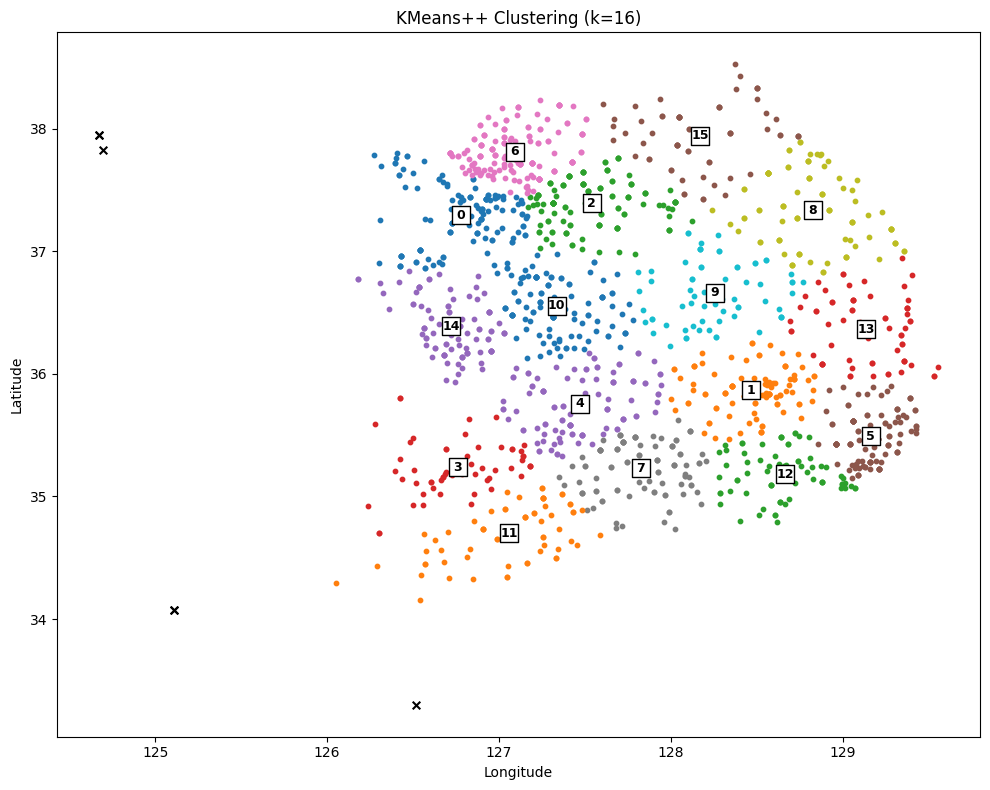

In [153]:
# 시각화
plt.figure(figsize=(10, 8))

for i in range(k):
    cluster_points = df[df['cluster'] == i]
    plt.scatter(cluster_points["경도"], cluster_points["위도"], s=10)

plt.scatter(centers[:, 1], centers[:, 0], c='white', edgecolors='black', marker='s', s=150, label='Centers')

# 중심점 위에 클러스터 번호 텍스트 표시
for i, (lat, lon) in enumerate(centers):
    plt.text(lon, lat, str(i), fontsize=9, color='black', ha='center', va='center', fontweight='bold')

df_outlier = df_all[is_outlier]
plt.scatter(df_outlier['경도'], df_outlier['위도'], s=30, c='black', marker='x', label='Outlier')

plt.title(f'KMeans++ Clustering (k={k})')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(False)
plt.tight_layout()
plt.show()